# Updated version (ver.2)

- ver.1.2

> step 1. Find both white Mura and black Mura

> step 2. Enumerate separated regions

> step 3. Calculate SEMU (background brightness is different for each defect, considering regional difference)

- ver.2

> Mainly focus on reading Tiff images


## 1. Find both white Mura and black Mura

In [1]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from matplotlib.pyplot import figure


(1200, 1600) C6AL9NC_C3_2_PM_L25_FMura.tif


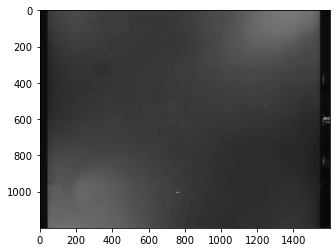

(1200, 1600) C6AL9NC_C3_2_PM_L128_FMura.tif


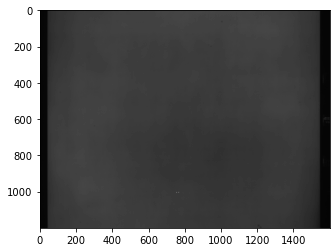

(1200, 1600) C6AL9NC_C3_2_PM_HGO_FMura.tif


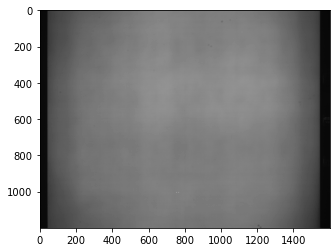

(1200, 1600) C6AL9NC_C3_2_PM_HM_FMura.tif


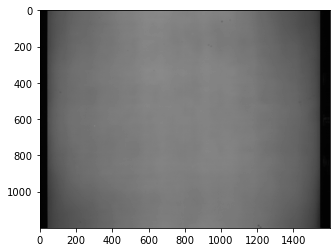

(1200, 1600) C6AL9NC_C3_2_PM_L48_FMura.tif


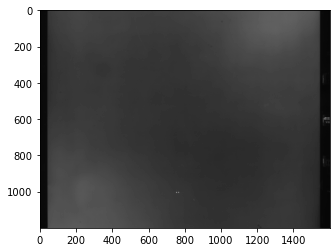

(1200, 1600) C6AL9NC_C3_2_PM_LM_FMura.tif


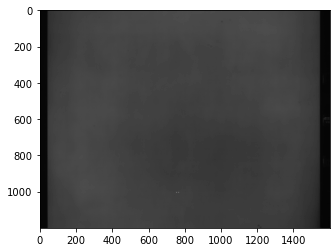

In [2]:
for file_name in os.listdir('/home/cov/Desktop/PML/project1_Mura/AUO_Data/JND_RAW_DATA/C6AL9NC/'):
    if not (".bmp" in file_name) and not (".db" in file_name):
        fname = '/home/cov/Desktop/PML/project1_Mura/AUO_Data/JND_RAW_DATA/C6AL9NC/'+file_name
        a = tiff.imread(fname)
        print(a.shape,file_name)
        plt.imshow(a, cmap='gray')
        plt.show()

(830, 1480)

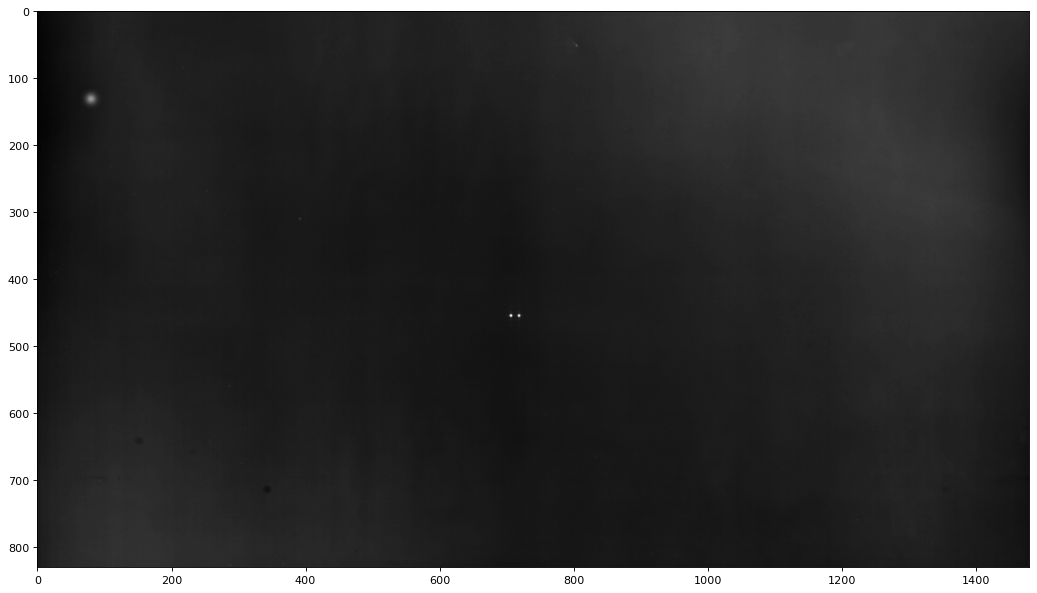

In [4]:
fname = "/home/cov/Desktop/PML/project1_Mura/AUO_Data/2nd/0826_2nd/DWL48/C53R5YA/C53R5YA_C3_3_PM_L48_FMura.tif"
img = tiff.imread(fname)
img = img[:830,50:1530]
imgFloat = img.astype('float')
coeff = cv2.dct(imgFloat)
coeff[:,3:]=0
coeff[3:][:]=0
reconsImg = cv2.idct(coeff)
diff = reconsImg-img
figure(figsize=(16, 12), dpi=80)
plt.imshow(imgFloat, cmap='gray')
img.shape
#print(type(img))
#plt.imshow(img)

0


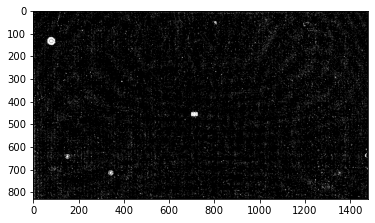

In [5]:
diff_n = cv2.normalize(diff, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
thresh1 = cv2.adaptiveThreshold(diff_n, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 2)# obtain white Mura
thresh2 = cv2.adaptiveThreshold(diff_n, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15,-2)# obtain black Mura
BothT = thresh1+thresh2
plt.imshow(BothT, cmap='gray')#, vmin=0, vmax=255)
print(BothT[20,20])

My param notes: (65,50), (5,1) (29,3) (25,2) (15,2) (3,1)

Also, increase the kernel size of median blur to 13 to reduce the noise. (larger image, larger kernel)

(830, 1480)

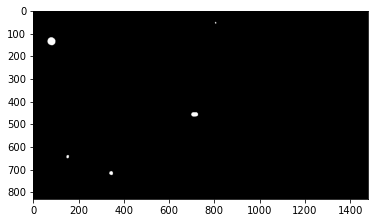

In [6]:
BothT2 = cv2.medianBlur(BothT, 11)
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(BothT2, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')#, vmin=0, vmax=255)
opening.shape
#cv2.imwrite('o.png',opening)

## 2. Enumerate separated regions

<class 'numpy.ndarray'> (830, 1480)
No.0 defect:


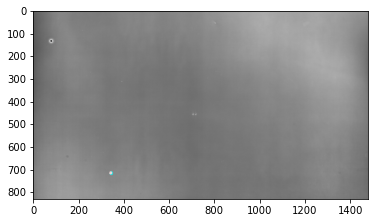

No.1 defect:


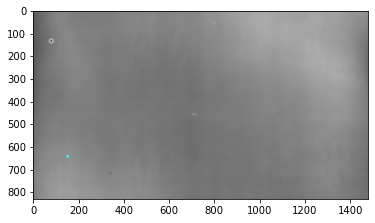

No.2 defect:


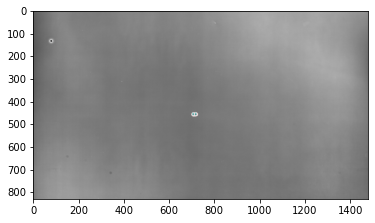

No.3 defect:


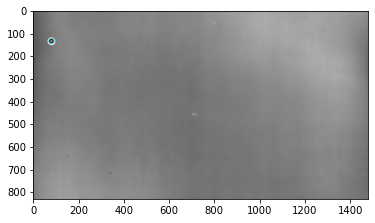

No.4 defect:


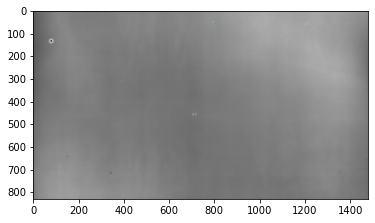

In [8]:
color = (255,200,200)#(200,200,200)
lst_dfcts = []
lst_bdbox = []
bdRect = []
print(type(opening),opening.shape)
_, opening2 = cv2.threshold(opening, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(opening2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for i in range(len(contours)):
    cimg,cimg2 = np.zeros_like(opening), np.zeros_like(opening)
    cv2.drawContours(cimg, contours, i, color, -1, cv2.LINE_8)
    pts = np.where(cimg == 255)
    lst_dfcts.append(img[pts[0], pts[1]]) # record the intensity at the defect pixels
    bdRect.append(cv2.boundingRect(contours[i]))
    cv2.rectangle(cimg2, (int(bdRect[i][0]), int(bdRect[i][1])),\
                  (int(bdRect[i][0]+bdRect[i][2]), int(bdRect[i][1]+bdRect[i][3])), 255, -1)
    pts2 = np.where(cimg2 == 255)
    lst_bdbox.append(img[pts2[0], pts2[1]])
    
for j in range(len(lst_dfcts)):
    drawing2 = np.zeros((opening.shape[0], opening.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(drawing2, contours, j, color, -1, cv2.LINE_8)#, hierarchy, 0) # -1 doesn't count the boundary

    for i in range(3): # overlay
        drawing2[:,:,i] = (drawing2[:,:,i] + img)/2
    
    print("No.{} defect:".format(j))
    plt.imshow(drawing2,cmap='gray')#, vmin=0, vmax=255)
    plt.show()

# 3. Calculate SEMU
## Calculate regional background intensity

Create a bounding box around the defect, the residual region is 

![How to calculate background intensity](a1.png)

- Yumi et.al did an experiment, and conclude that the JND contrast, $C_{jnd}$, can be expressed as $$C_{jnd}=\frac{1.97}{S^{0.33}}+0.72$$ (result of linear regression), where $S$ is the number of pixels of the defects.
Contrast value below $C_{jnd}$ can be viewed as no defect.

SEMI further defined the severity of a Mura defect. $$SEMU = \frac{|C_x|}{C_{jnd}}$$ where $|C_x|=\dfrac{|I_O-I_{Background}|}{I_{Background}}\times 100\%$ is the average contrast

In [7]:
I_Back = []
for i in range(len(lst_dfcts)):
    I_Back.append((sum(lst_bdbox[i])-sum(lst_dfcts[i]))/(len(lst_bdbox[i])-len(lst_dfcts[i])))

C_i = []
C_jnd_i = []
Semu_i = []

for i in range(len(lst_dfcts)):
    C_i.append(abs(I_Back[i]-sum(lst_dfcts[i])/len(lst_dfcts[i]))/I_Back[i]*100)
#     C_jnd_i.append(1.97/((0.009*(len(lst_dfcts[i]))**0.5)**0.33) + 0.72)
    #C_jnd_i.append(1.97/((0.01*(len(lst_dfcts[i]))**0.5)**0.165) + 0.72+0.9)
    C_jnd_i.append(1.97/((0.0002*len(lst_dfcts[i]))**0.33) + 0.72)

    Semu_i.append(C_i[i]/C_jnd_i[i])
C_jnd_i

[6.242387062212906,
 7.30615160174211,
 4.9571070368724,
 4.104477687271891,
 10.755673009590723]

---------------------------
No.0 defect, Semu = 1.0988846823543028


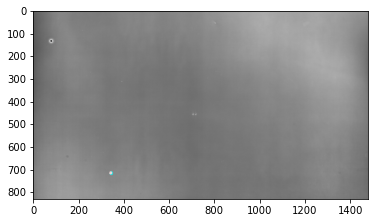

---------------------------
No.1 defect, Semu = 0.8136176262922936


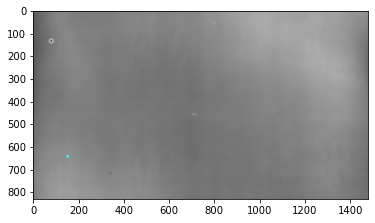

---------------------------
No.2 defect, Semu = 4.128762064898508


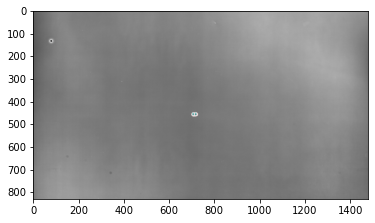

---------------------------
No.3 defect, Semu = 7.101734410568326


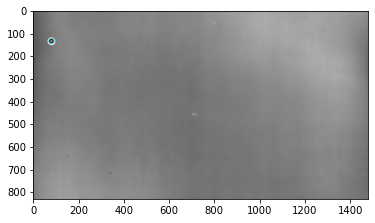

---------------------------
No.4 defect, Semu = 0.6764540048078286


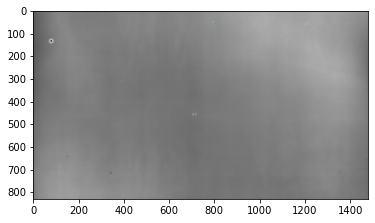

In [8]:
for j in range(len(lst_dfcts)):
    drawing2 = np.zeros((opening.shape[0], opening.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(drawing2, contours, j, color, -1, cv2.LINE_8)
    for i in range(3): # overlay
        drawing2[:,:,i] = (drawing2[:,:,i] + img)/2
    #drawing3 = drawing2 * (drawing2 < 255)
    print("---------------------------\nNo.{} defect, Semu = {}".format(j,Semu_i[j]))
    plt.imshow(drawing2)
    plt.show()

In [9]:
for i in range(len(lst_dfcts)):
    print("defect",i,"","# of pixels:",len(lst_dfcts[i]))
    print("\tbackground intensity:",I_Back[i])

defect 0  # of pixels: 220
	background intensity: 265.27906976744185
defect 1  # of pixels: 129
	background intensity: 281.19607843137254
defect 2  # of pixels: 491
	background intensity: 231.8139534883721
defect 3  # of pixels: 970
	background intensity: 238.64723926380367
defect 4  # of pixels: 36
	background intensity: 292.7037037037037


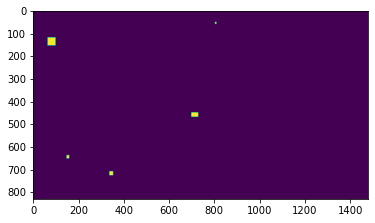

In [10]:
cimg,cimg2 = np.zeros_like(opening), np.zeros_like(opening)
for i in range(len(contours)):
    cv2.drawContours(cimg, contours, i, color, -1, cv2.LINE_8)#, hierarchy, 0)
    # cv2.drawContours(drawing, contours, i, color, -1, cv2.LINE_8, hierarchy, 0)
    pts = np.where(cimg == 255)
    lst_dfcts.append(img[pts[0], pts[1]]) # record the intensity at the defect pixels
    bdRect.append(cv2.boundingRect(contours[i]))
    cv2.rectangle(cimg2, (int(bdRect[i][0]), int(bdRect[i][1])),\
                  (int(bdRect[i][0]+bdRect[i][2]), int(bdRect[i][1]+bdRect[i][3])), 255, -1)
    pts2 = np.where(cimg2 == 255)
    lst_bdbox.append(img[pts2[0], pts2[1]])
    plt.imshow(cimg2)

In [69]:
img

array([[128, 130, 132, ..., 180, 173, 177],
       [123, 125, 125, ..., 169, 175, 173],
       [126, 125, 127, ..., 172, 169, 165],
       ...,
       [135, 132, 132, ..., 129, 128, 125],
       [129, 131, 137, ..., 144, 140, 140],
       [136, 136, 135, ..., 148, 140, 138]], dtype=uint16)

In [70]:
img > 0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [72]:
min(img + 2, 112)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [81]:
img * (img+2 > 130)

array([[  0, 130, 132, ..., 180, 173, 177],
       [  0,   0,   0, ..., 169, 175, 173],
       [  0,   0,   0, ..., 172, 169, 165],
       ...,
       [135, 132, 132, ..., 129,   0,   0],
       [129, 131, 137, ..., 144, 140, 140],
       [136, 136, 135, ..., 148, 140, 138]], dtype=uint16)